In [3]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning

In [4]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset
# df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

In [5]:
# cleaning some movies columns 
df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(cleaning.clean_idxs)
df_movies['countries'] = df_movies['countries'].apply(cleaning.clean_idxs)
df_movies['genres'] = df_movies['genres'].apply(cleaning.clean_idxs)

# clean movies dates to keep the release year only
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)

In [6]:
# clean characters dates to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

At this point df_movies and df_characters are cleaned and their size did not change

Text(0.5, 1.0, 'Movies distribution by release date')

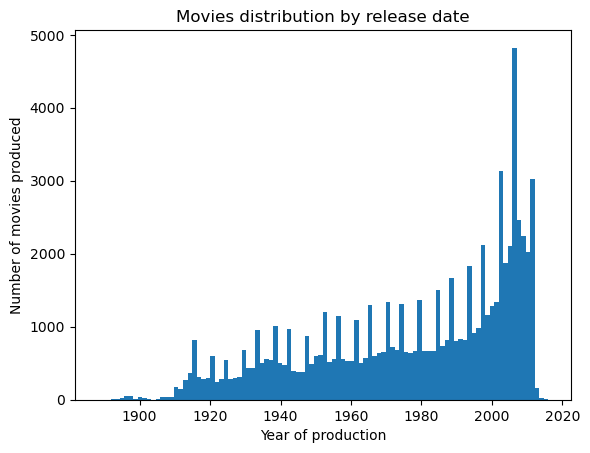

In [7]:
# filtering movies release dates (first ever produced movie: 1888)
df_movies_release = df_movies[df_movies['release_date'] > 1887]
df_movies_release = df_movies_release.dropna(subset=['release_date'])

# movies distribution wrt release date
plt.figure()
plt.hist(df_movies_release['release_date'], bins= 100)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.title('Movies distribution by release date')


In [8]:
print(diagnostic.kstest_normal(df_movies_release['release_date'].values, dist = 'exp'))
print(diagnostic.kstest_normal(df_movies_release['release_date'].values, dist = 'norm'))

# reject both hypothesis of normal or exponential dist

(0.6161695771467867, 0.0009999999999998899)
(0.12534046369911533, 0.0009999999999998899)


In [9]:
# defining a dataframe with non-nan revenues, observe that 90% of the
# original revenue values are missing --> losing a lot of data
df_movies_revenue = df_movies.dropna(subset=['revenue'])

# filtering release dates
df_movies_revenue = df_movies_revenue[df_movies_revenue['release_date'] > 1887]

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(29.000000000000007, 0.5, 'Revenue (USD)')

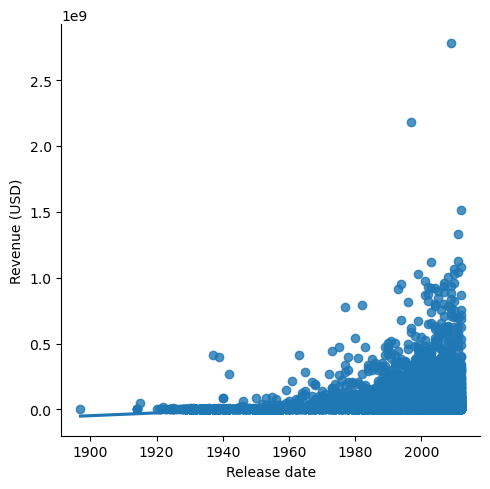

In [10]:
# scatter-plots to assess possible regressions
# revenue-release_date
#sns.scatterplot(x='release_date', y='revenue', data=df_movies_revenue)
sns.lmplot(x='release_date',y='revenue', data=df_movies_revenue)
plt.xlabel("Release date")
plt.ylabel("Revenue (USD)")

In [11]:
df_movies_revenue['revenue'].describe()

count    8.327000e+03
mean     4.826762e+07
std      1.124679e+08
min      1.000000e+04
25%      2.102500e+06
50%      1.080432e+07
75%      4.105011e+07
max      2.782275e+09
Name: revenue, dtype: float64

In [12]:
# testing if revenue dist is normal
diagnostic.kstest_normal(df_movies_revenue['revenue'].values, dist = 'norm')

# p_value < 0.05 --> reject normal dist hypothesis

(0.3339328046168235, 0.0009999999999998899)

In [13]:
# testing if revenue dist is exp
diagnostic.kstest_normal(df_movies_revenue['revenue'].values, dist = 'exp')

# p_value < 0.05 --> reject exponetnial dist hypothesis

(0.3017419770504368, 0.0009999999999998899)

In [14]:
# linear regression (even tho data is hardly linearly fittable)
df_movies_release_revenue = df_movies.dropna(subset=['release_date', 'revenue'])

mod = smf.ols(formula='revenue ~ release_date', data=df_movies_release_revenue)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     231.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.17e-51
Time:                        16:52:30   Log-Likelihood:            -1.6609e+05
No. Observations:                8328   AIC:                         3.322e+05
Df Residuals:                    8326   BIC:                         3.322e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.592e+09   1.08e+08    -14.777   

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(29.000000000000007, 0.5, 'Revenue (USD)')

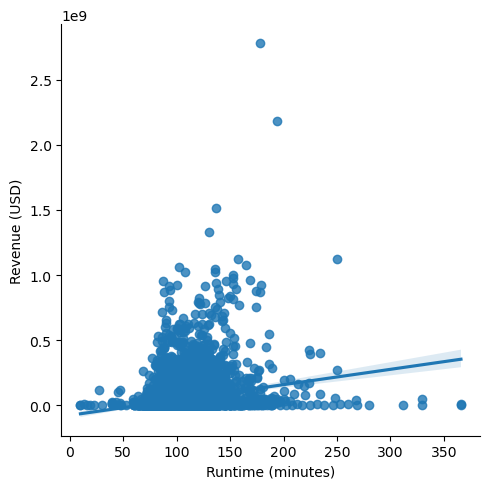

In [15]:
# on runtime movies need to be filtered (arbitrary limit, needs to be investigated)
df_movies_runtime = df_movies.dropna(subset=['runtime'])
df_movies_runtime = df_movies_runtime[df_movies_runtime['runtime'] < 400]
df_movies_runtime = df_movies_runtime[df_movies_runtime['runtime'] != 0]

# revenue-runtime
#sns.scatterplot(x='runtime', y='revenue', data=df_movies_runtime)
sns.lmplot(x='runtime',y='revenue', data=df_movies_runtime)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue (USD)")

In [16]:
df_movies_runtime['runtime'].describe()

count    61224.000000
mean        92.837552
std         34.404886
min          0.030000
25%         81.000000
50%         93.000000
75%        106.000000
max        399.000000
Name: runtime, dtype: float64

In [17]:
# testing if revenue dist is normal
diagnostic.kstest_normal(df_movies_runtime['runtime'], dist = 'norm')

# p_value < 0.05 --> reject normal dist hypothesis

(0.1265427427404939, 0.0009999999999998899)

In [18]:
# testing if revenue dist is exp
diagnostic.kstest_normal(df_movies_runtime['runtime'], dist = 'exp')

# p_value < 0.05 --> reject exp dist hypothesis

(0.3736186884164211, 0.0009999999999998899)

In [19]:
# linear regression (even tho data is hardly linearly fittable)
df_movies_runtime_revenue = df_movies.dropna(subset=['runtime', 'revenue'])

mod = smf.ols(formula='revenue ~ runtime', data=df_movies_runtime_revenue)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     306.9
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.69e-67
Time:                        16:52:31   Log-Likelihood:            -1.6553e+05
No. Observations:                8302   AIC:                         3.311e+05
Df Residuals:                    8300   BIC:                         3.311e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.718e+07   5.57e+06     -8.462      0.0

In [20]:
# linear regression with both release_date and runtime, without interaction
df_movies_release_revenue_runtime = df_movies.dropna(subset=['release_date',
                                                             'revenue', 'runtime'])

mod = smf.ols(formula='revenue ~ runtime + release_date', data=df_movies_release_revenue_runtime)
res = mod.fit()
print(res.summary())

# linear regression with both release_date and runtime, with interaction
mod = smf.ols(formula='revenue ~ runtime * release_date', data=df_movies_release_revenue_runtime)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     263.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          9.15e-112
Time:                        16:52:31   Log-Likelihood:            -1.6427e+05
No. Observations:                8243   AIC:                         3.285e+05
Df Residuals:                    8240   BIC:                         3.286e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.622e+09   1.07e+08    -15.135   

In [21]:
# perform stats.pearsonr on first two regressions. Attention: need to merge first and drop nan
print(stats.pearsonr(df_movies_release_revenue['release_date'], df_movies_release_revenue['revenue']))
print(stats.pearsonr(df_movies_runtime_revenue['runtime'], df_movies_runtime_revenue['revenue']))

# both p-values < 0.05 --> significant positive correlation
# observe that R2 for both regressions was low --> low variance explained by predictors
# this is confirmed by the (statistically meaningful) Pearson's coefficients, which are indeed low

PearsonRResult(statistic=0.16459114274766695, pvalue=1.1735707009297993e-51)
PearsonRResult(statistic=0.18882898518338603, pvalue=1.6862552263568505e-67)


c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


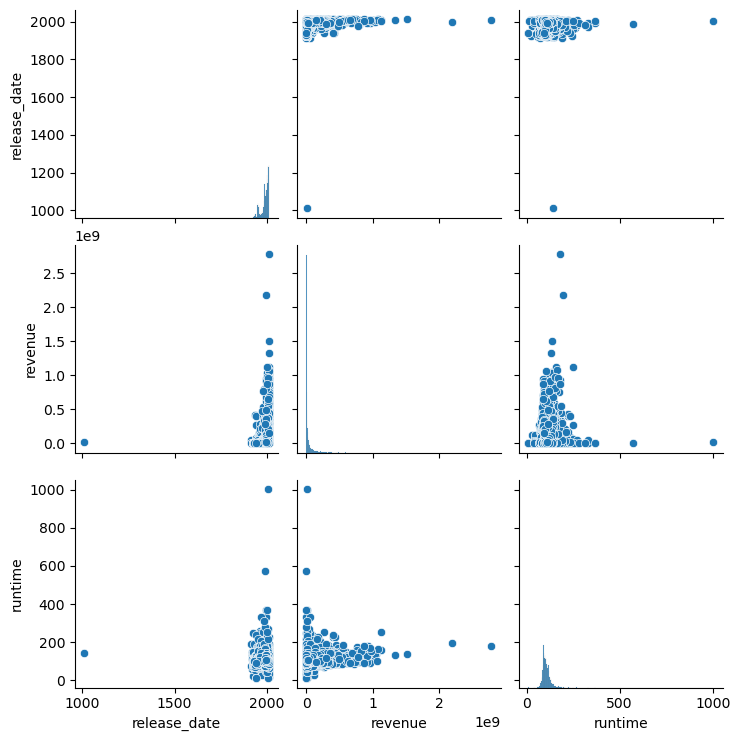

In [22]:
sns.pairplot(df_movies_release_revenue_runtime[['release_date', 'revenue', 'runtime']])

In [25]:
# plots tokenization
import tiktoken

def tokenize_text(s):
    enc = tiktoken.encoding_for_model('gpt-4o')
    tokens = enc.encode(str(s))
    return tokens

df_plots['tokenized'] = df_plots['plot_summary'].apply(lambda s: tokenize_text(s))
